In [ ]:
!pip install gTTS
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov4
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
!chmod +x ./darknet
!ls data/
#pwd



from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline




# import darknet functions to perform object detections
!pip install darknet
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/yolov4.data.txt", "/mydrive/yolov4/darknet/backup/yolov4-custom_last.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes  

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
        
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
      from gtts import gTTS
      from IPython.display import Audio, display
      if label=='car':
        text = "This is a car"
      
# Create a gTTS object and set language to English
        tts = gTTS(text=text, lang='en')

# Save the audio file
        tts.save('/mydrive/test_videos/test.mp3')

# Play the audio file
        display(Audio('/mydrive/test_videos/test.mp3', autoplay=True))
      if label=='bus':
         text = "This is a bus"
      
# Create a gTTS object and set language to English
         tts = gTTS(text=text, lang='en')

# Save the audio file
         tts.save('/mydrive/test_videos/test1.mp3')

# Play the audio file
         display(Audio('/mydrive/test_videos/test1.mp3', autoplay=True))

      if label=='three wheelers -CNG-':
         text = "This is a three wheeler"
      
# Create a gTTS object and set language to English
         tts = gTTS(text=text, lang='en')

# Save the audio file
         tts.save('/mydrive/test_videos/test2.mp3')

# Play the audio file
         display(Audio('/mydrive/test_videos/test2.mp3', autoplay=True))

      if label=='truck':
         text = "This is a truck"
      
# Create a gTTS object and set language to English
         tts = gTTS(text=text, lang='en')

# Save the audio file
         tts.save('/mydrive/test_videos/test3.mp3')

# Play the audio file
         display(Audio('/mydrive/test_videos/test3.mp3', autoplay=True))         

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(float) * 255
      #print(label)
    # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
      bbox = bbox_bytes  
      #print(label) 


      








         

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/yolov4
/content/gdrive/My Drive/yolov4/darknet
labels	test.txt  train.txt  yolov4  yolov4.data.txt  yolov4.mp3  yolov4.names
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<IPython.core.display.Javascript object>

In [ ]:
!git clone https://github.com/AlexeyAB/darknet
!pip install gTTS
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov4
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
!chmod +x ./darknet
!ls data/

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.16 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (10413/10413), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive
/content/gdrive/My Drive/yolov4
/content/gdrive/My Drive/yolov4/darknet
labels	test.txt  train.txt  yolov4  yolov4.data.txt  yolov4.mp3  yolov4.names


In [ ]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |

In [ ]:
!python process.py

In [ ]:
!./darknet detector train data/yolov4.data.txt cfg/yolov4-custom.cfg yolov4.conv.137.2  -dont_show 

 CUDA-version: 11020 (11020), cuDNN: 8.1.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
yolov4-custom
subdivisions: Using default '1'
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 6, batch = 6, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     32       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  32 0.797 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  32 0.089 BF
   3 route  1 		                           ->  208 x 208 x  32 
   4 conv     64       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  64 0.177 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, 

In [ ]:
!./darknet detector train data/yolov4.data.txt cfg/yolov4-custom.cfg /mydrive/yolov4/darknet/backup/yolov4-custom_last.weights -dont_show -map


 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 Prepare additional network for mAP calculation...
subdivisions: Using default '1'
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     32       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  32 0.797 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  32 0.089 BF
   3 route  1 		                           ->  208 x 208 x  32 
   4 conv     64       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  64 0.177 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7

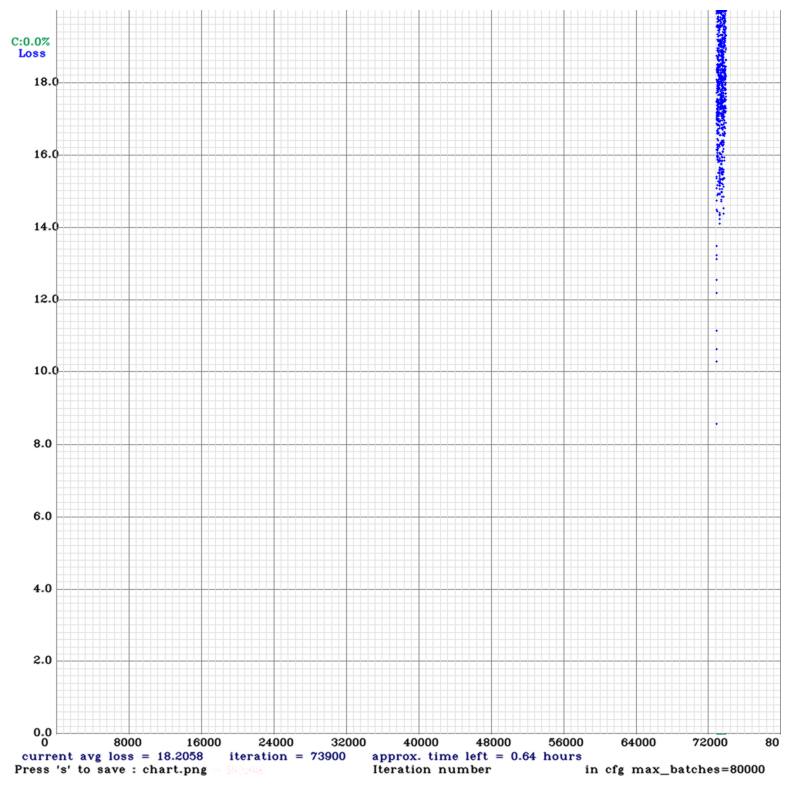

In [ ]:

imShow('chart.png')

In [ ]:
##You can check the mAP for all the saved weights to see which gives the best results ( xxxx here is the saved weight number like 4000, 5000 or 6000 snd so on )

!./darknet detector map data/yolov4.data.txt cfg/yolov4-custom.cfg /mydrive/yolov4/darknet/backup/yolov4-custom_last.weights -points 0

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
subdivisions: Using default '1'
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     32       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  32 0.797 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  32 0.089 BF
   3 route  1 		                           ->  208 x 208 x  32 
   4 conv     64       1 x 1/ 1    208 x 208 x  32 ->  208 x 208 x  64 0.177 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x

In [ ]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/MyDrive/yolov4/darknet/cfg
/content/gdrive/MyDrive/yolov4/darknet


In [ ]:
from google.colab.patches import cv2_imshow
import cv2


In [ ]:
# define helper function imShow
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()


 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
^C


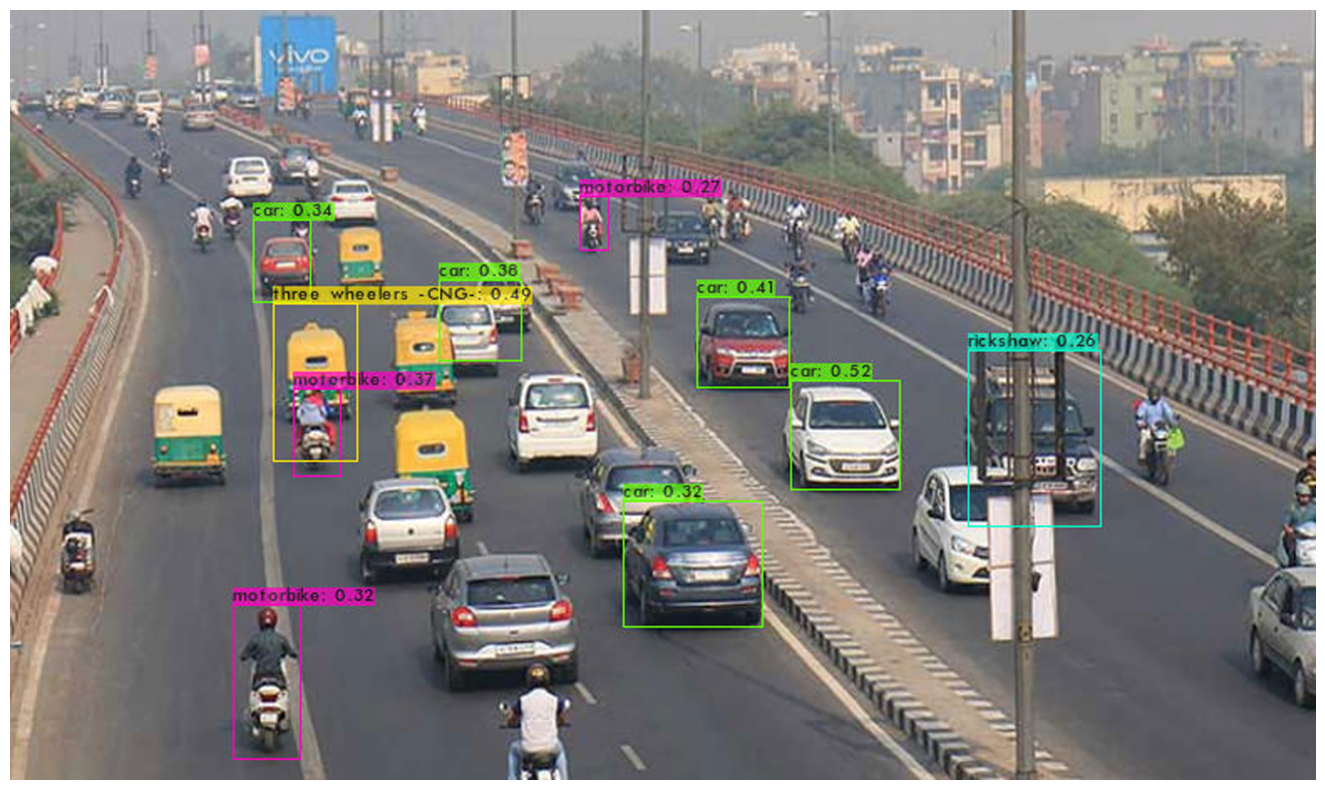

In [ ]:
!./darknet detector test data/yolov4.data.txt cfg/yolov4-custom.cfg /mydrive/yolov4/darknet/backup/yolov4-custom_last.weights /mydrive/test_images/image3.jpg 
imShow('predictions.jpg')

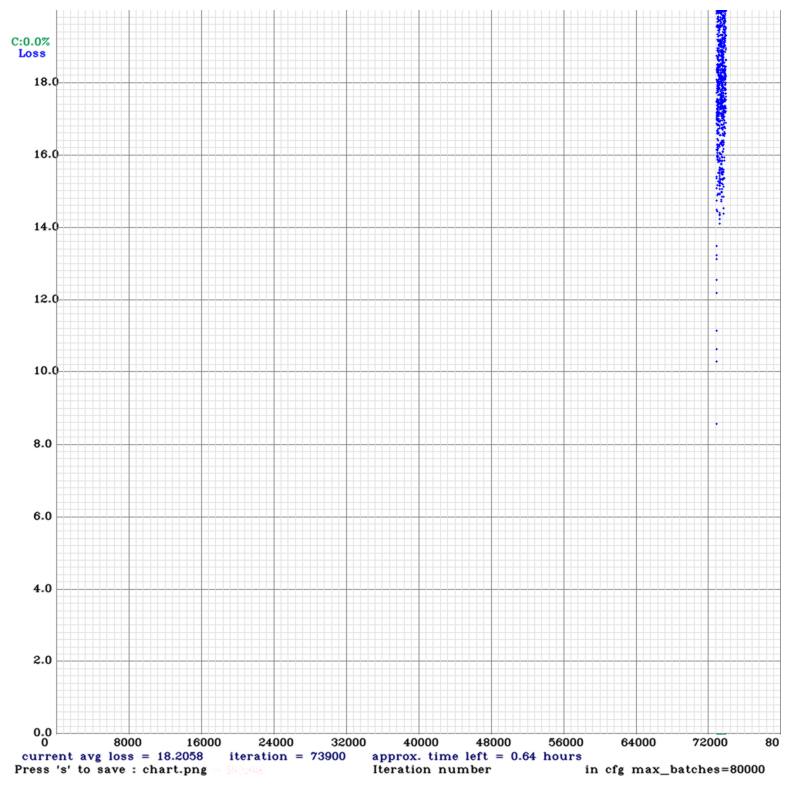

In [ ]:
imShow('chart.png')

In [ ]:
#run detector on images captured by webcam for your custom YOLOv4 trained model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

!./darknet detector test data/yolov4.data.txt cfg/yolov4-custom.cfg /mydrive/yolov4/darknet/backup/yolov4-custom_final.weights /mydrive/test_images/image1.jpg 
imShow('photo.jpg')  

In [ ]:
# run your custom detector on a video with this command (upload a video to your google drive to test, the thresh flag sets the minimum accuracy required for object detection).This saves the output video with the detections in your output path

!./darknet detector demo data/yolov4.data.txt cfg/yolov4-custom.cfg /mydrive/yolov4/darknet/backup/yolov4-custom_last.weights -dont_show /mydrive/test_videos/test2.mp4 -i 0 -out_filename /mydrive/test_videos/finalresult.avi 

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
^C


In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.4)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
     

In [ ]:
#Running on Webcam Video

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
     


<IPython.core.display.Javascript object>

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov4
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
!chmod +x ./darknet
!ls data/


Mounted at /content/gdrive
/content/gdrive/My Drive/yolov4
/content/gdrive/My Drive/yolov4/darknet
labels	test.txt  train.txt  yolov4  yolov4.data.txt  yolov4.mp3  yolov4.names
